In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [21]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [22]:
df = pd.read_csv('../data/raw/daily-website-visitors.csv', parse_dates=['Date'])

In [23]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
numeric_columns = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
for col in numeric_columns:
    df[col] = df[col].str.replace(',', '').astype(int)

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2167 entries, 2014-09-14 to 2020-08-19
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Page.Loads         2167 non-null   int32 
 4   Unique.Visits      2167 non-null   int32 
 5   First.Time.Visits  2167 non-null   int32 
 6   Returning.Visits   2167 non-null   int32 
dtypes: int32(4), int64(2), object(1)
memory usage: 101.6+ KB
None
            Row        Day  Day.Of.Week  Page.Loads  Unique.Visits  \
Date                                                                 
2014-09-14    1     Sunday            1        2146           1582   
2014-09-15    2     Monday            2        3621           2528   
2014-09-16    3    Tuesday            3        3698           2630   
2014-09-17    4  Wednesday          

In [24]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week
df['Day'] = df.index.day
df['Day_Of_Week'] = df.index.dayofweek 
df['Is_Weekend'] = (df['Day_Of_Week'] >= 5).astype(int)

df['Lag_1'] = df['Page.Loads'].shift(1)
df['Lag_7'] = df['Page.Loads'].shift(7)

df['Rolling_Mean_7'] = df['Page.Loads'].rolling(window=7).mean()

df.dropna(inplace=True)

print(df.head())

            Row  Day  Day.Of.Week  Page.Loads  Unique.Visits  \
Date                                                           
2014-09-21    8   21            1        2288           1656   
2014-09-22    9   22            2        3638           2586   
2014-09-23   10   23            3        4462           3257   
2014-09-24   11   24            4        4414           3175   
2014-09-25   12   25            5        4315           3029   

            First.Time.Visits  Returning.Visits  Year  Month  Week  \
Date                                                                 
2014-09-21               1481               175  2014      9    38   
2014-09-22               2312               274  2014      9    39   
2014-09-23               2989               268  2014      9    39   
2014-09-24               2891               284  2014      9    39   
2014-09-25               2743               286  2014      9    39   

            Day_Of_Week  Is_Weekend   Lag_1   Lag_7  Rolling

In [25]:
split_point = int(len(df) * 0.8)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

print(f"Training Set Shape: {train.shape}")
print(f"Testing Set Shape: {test.shape}")

features = ['Unique.Visits', 'First.Time.Visits', 'Returning.Visits', 
            'Day_Of_Week', 'Is_Weekend', 'Lag_1', 'Lag_7', 'Rolling_Mean_7']
target = 'Page.Loads'

X = df[features]
y = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


Training Set Shape: (1728, 15)
Testing Set Shape: (432, 15)
X_train shape: (1728, 8), X_test shape: (432, 8)
y_train shape: (1728,), y_test shape: (432,)


c:\Users\KSCOM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\KSCOM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\KSCOM\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


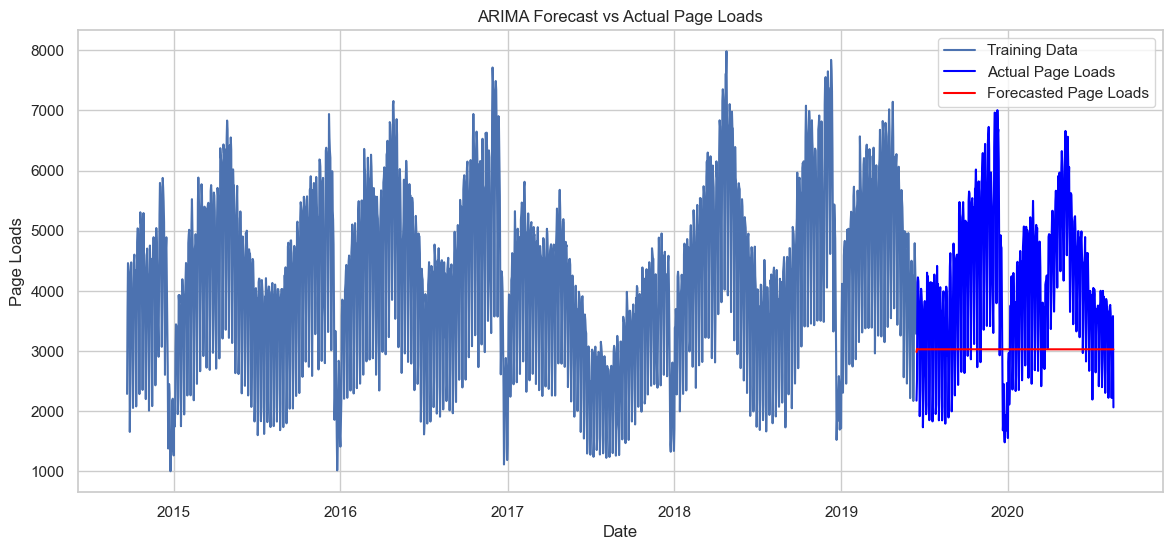

ARIMA Model RMSE: 1562.26


In [26]:
train_series = train['Page.Loads']
test_series = test['Page.Loads']

model = ARIMA(train_series, order=(1, 1, 1))
model_fit = model.fit()

forecast_steps = len(test_series)
forecast = model_fit.forecast(steps=forecast_steps)

plt.figure(figsize=(14, 6))
plt.plot(train_series.index, train_series, label='Training Data')
plt.plot(test_series.index, test_series, label='Actual Page Loads', color='blue')
plt.plot(test_series.index, forecast, label='Forecasted Page Loads', color='red')
plt.title('ARIMA Forecast vs Actual Page Loads')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(test_series, forecast))
print(f"ARIMA Model RMSE: {rmse:.2f}")

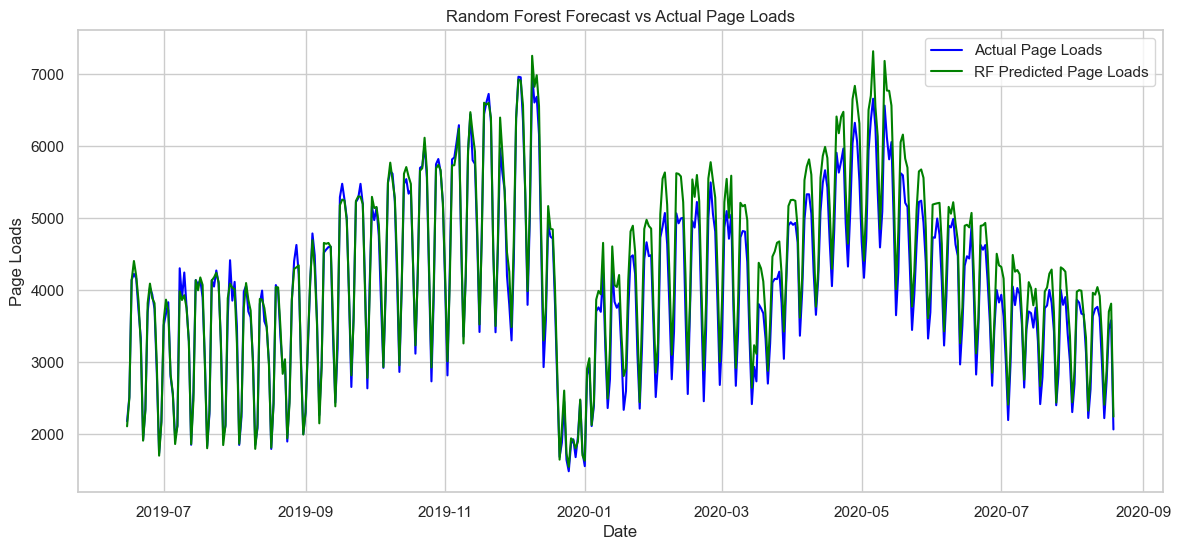

Random Forest Model RMSE: 300.89


In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual Page Loads', color='blue')
plt.plot(y_test.index, rf_predictions, label='RF Predicted Page Loads', color='green')
plt.title('Random Forest Forecast vs Actual Page Loads')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest Model RMSE: {rf_rmse:.2f}")

In [28]:
import numpy as np
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
arima_rmse = np.sqrt(mean_squared_error(test_series, forecast))
arima_mape = mean_absolute_percentage_error(test_series, forecast)

print(f"ARIMA Model RMSE: {arima_rmse:.2f}")
print(f"ARIMA Model MAPE: {arima_mape:.2f}%")


ARIMA Model RMSE: 1562.26
ARIMA Model MAPE: 29.90%


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
best_rf_predictions = best_rf.predict(X_test)

best_rf_rmse = np.sqrt(mean_squared_error(y_test, best_rf_predictions))
best_rf_mape = mean_absolute_percentage_error(y_test, best_rf_predictions)

print(f"Tuned Random Forest RMSE: {best_rf_rmse:.2f}")
print(f"Tuned Random Forest MAPE: {best_rf_mape:.2f}%")


Best parameters found: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Random Forest RMSE: 299.46
Tuned Random Forest MAPE: 5.95%


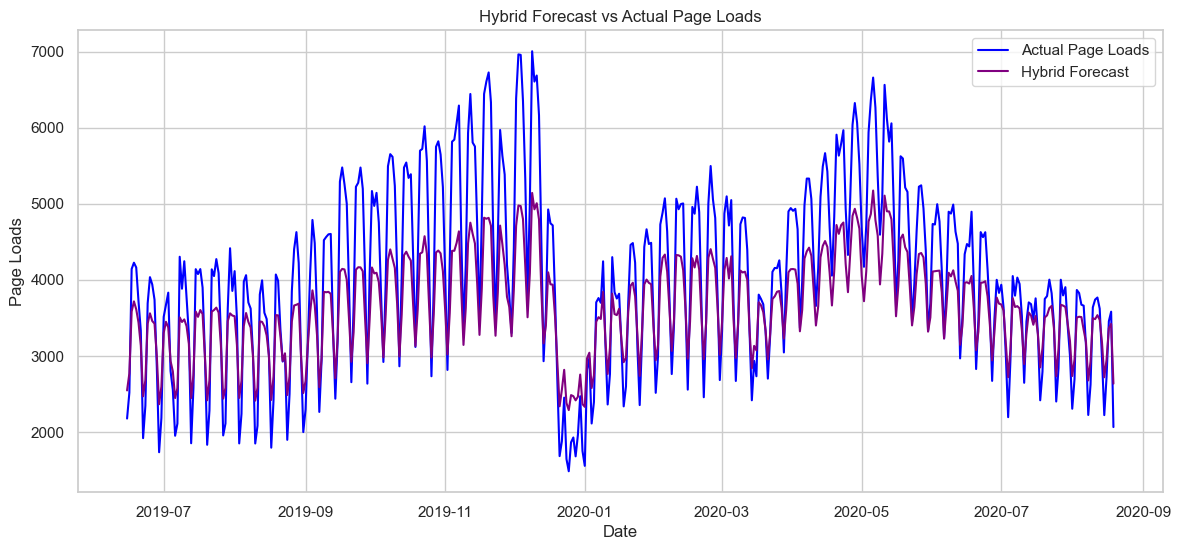

Hybrid Model RMSE: 702.84
Hybrid Model MAPE: 13.47%


In [31]:
hybrid_forecast = (forecast.values + rf_predictions) / 2

plt.figure(figsize=(14, 6))
plt.plot(test_series.index, test_series, label='Actual Page Loads', color='blue')
plt.plot(test_series.index, hybrid_forecast, label='Hybrid Forecast', color='purple')
plt.title('Hybrid Forecast vs Actual Page Loads')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.show()

hybrid_rmse = np.sqrt(mean_squared_error(test_series, hybrid_forecast))
hybrid_mape = mean_absolute_percentage_error(test_series, hybrid_forecast)

print(f"Hybrid Model RMSE: {hybrid_rmse:.2f}")
print(f"Hybrid Model MAPE: {hybrid_mape:.2f}%")


In [32]:
deployment_df = pd.DataFrame({
    'Date': test_series.index,
    'Actual': test_series.values,
    'Forecast': hybrid_forecast
})
deployment_df.to_csv('../data/processed/forecast_data.csv', index=False)
print("Forecast data saved to '../data/processed/forecast_data.csv'")


Forecast data saved to '../data/processed/forecast_data.csv'
